In [1]:
import imprint.nb_util as nb_util
nb_util.setup_nb()

import time
import jax
import jax.numpy as jnp
from jax.scipy.special import expit, logit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import confirm.models.wd41 as wd41
import imprint as ip

## Exploring

We have two subgroups, each split equally into treatment and control arms:
- $p_{\mathrm{TNBC}}^{c}$ - TNBC subgroup control arm effectiveness.
- $p_{\mathrm{TNBC}}^{t}$ - TNBC subgroup treatment arm effectiveness.
- $p_{\mathrm{HR+}}^{c}$ - HR+ subgroup control arm effectiveness.
- $p_{\mathrm{HR+}}^{t}$ - HR+ subgroup treatment arm effectiveness.
  
$f_{\mathrm{TNBC}}$ is the fraction of patients in the TNBC subgroup.

The null hypotheses here are:

$$
p_{\mathrm{TNBC}}^{c} > p_{\mathrm{TNBC}}^{t}
$$

$$
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{c} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{c} > 
f_{\mathrm{TNBC}} p_{\mathrm{TNBC}}^{t} + (1 - f_{\mathrm{TNBC}}) p_{\mathrm{HR+}}^{t}
$$

Adaptive Dunnett tests for treatment selection: https://pubmed.ncbi.nlm.nih.gov/17876763/

## Bigger job

In [2]:
from confirm.adagrid import ada_calibrate

In [3]:
model = wd41.WD41(0, 1, ignore_intersection=True)
grid = ip.cartesian_grid(
    [-2.5, -2.5, -2.5, -2.5],
    [1.0, 1.0, 1.0, 1.0],
    n=[10, 10, 10, 10],
    null_hypos = model.null_hypos
)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=10000, worker_id=1, t=1677617488, n_bits=18, worker_bits=18) = [4604531496265711616 4604531496265711617 4604531496265711618, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 2 but grid has dimension 4. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 2 but grid has dimension 4. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 2 but grid has dimension 4. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 2 but grid has dimension 4. Padding with zeros.
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=2000, worker_id=1, t=1677617489, n_bits=18, worker_bits=18) = [4604531564985188352 4604531564985188353 4604531564985188354, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=5584, worker_id=1, t=1677617490, n_bits=18, worker_bits=18) = [4604531633704665088 4604531633704665089 4604531633704665090, ...]:


In [4]:
db = ada_calibrate(
    wd41.WD41,
    g=grid,
    alpha=0.025,
    bias_target=0.005,
    grid_target=0.005,
    std_target=0.01,
    n_K_double=6,
    calibration_min_idx=80,
    step_size=2**13,
    packet_size=2**12,
    model_kwargs={'ignore_intersection': True}
)

DEBUG:confirm.adagrid.adagrid:{'n_processed': 3666,
 'runtime_full_iter': '16.063751',
 'runtime_get_work': '0.003024',
 'runtime_processing': '16.014401',
 'runtime_update_step_info': '0.000774',
 'runtime_wait_for_lock': '0.000477',
 'status': 'WORK',
 'step_id': 10,
 'step_iter': 2,
 'step_n_iter': 9,
 'step_n_tiles': 32996,
 'waitings': 0,
 'work_extraction_time': '1677617966.601685',
 'worker_id': 2,
 'worker_iter': 68}
DEBUG:confirm.adagrid.adagrid:Starting loop 0.
DEBUG:confirm.adagrid.adagrid:Claimed DB lock.
DEBUG:confirm.adagrid.adagrid:get_work(step_id=10, step_iter=3)
DEBUG:confirm.adagrid.adagrid:get_work(...) returned 3666 tiles.
DEBUG:confirm.adagrid.adagrid:Processing 3666 tiles.
DEBUG:confirm.adagrid.adagrid:{'n_processed': 3666,
 'runtime_full_iter': '15.711369',
 'runtime_get_work': '0.003032',
 'runtime_processing': '15.662467',
 'runtime_update_step_info': '0.000798',
 'runtime_wait_for_lock': '0.000473',
 'status': 'WORK',
 'step_id': 10,
 'step_iter': 3,
 'step_n

In [5]:
results_df = db.get_results()

In [8]:
results_df['impossible']

0         True
1         True
2         True
3         True
4         True
          ... 
384954    True
384955    True
384956    True
384957    True
384958    True
Name: impossible, Length: 384959, dtype: bool

In [16]:
db.next(8192, "orderer")

,id,active,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,step_id,step_iter,creator_id,creation_time,processor_id,processing_time,eligible,grid_cost,impossible,orderer,K,alpha0,idx,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,B_lams20,B_lams21,B_lams22,B_lams23,B_lams24,B_lams25,B_lams26,B_lams27,B_lams28,B_lams29,B_lams30,B_lams31,B_lams32,B_lams33,B_lams34,B_lams35,B_lams36,B_lams37,B_lams38,B_lams39,B_lams40,B_lams41,B_lams42,B_lams43,B_lams44,B_lams45,B_lams46,B_lams47,B_lams48,B_lams49,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_lams6,twb_lams7,twb_lams8,twb_lams9,twb_lams10,twb_lams11,twb_lams12,twb_lams13,twb_lams14,twb_lams15,twb_lams16,twb_lams17,twb_lams18,twb_lams19,twb_lams20,twb_lams21,twb_lams22,twb_lams23,twb_lams24,twb_lams25,twb_lams26,twb_lams27,twb_lams28,twb_lams29,twb_lams30,twb_lams31,twb_lams32,twb_lams33,twb_lams34,twb_lams35,twb_lams36,twb_lams37,twb_lams38,twb_lams39,twb_lams40,twb_lams41,twb_lams42,twb_lams43,twb_lams44,twb_lams45,twb_lams46,twb_lams47,twb_lams48,twb_lams49
0,4604597329524695507,True,4604597123366257753,0.8250,0.1250,-0.9250,-0.5750,0.1750,0.1750,0.1750,0.1750,True,False,13,1,2,1.677618e+09,2,1.677618e+09,True,0.024918,True,-inf,524288,0.000082,42,0.070616,0.057081,0.048967,0.054338,0.052078,0.064974,0.064974,0.067708,0.061117,0.066864,0.055747,0.053292,0.069294,0.052078,0.053387,0.056590,0.068630,0.066020,0.054243,0.055747,0.053387,0.052078,0.069425,0.067708,0.069255,0.069425,0.052050,0.055747,0.056590,0.053292,0.054338,0.054338,0.054243,0.052078,0.052461,0.053292,0.047863,0.069294,0.054243,0.052078,0.053387,0.069261,0.052050,0.061117,0.061117,0.066020,0.048635,0.052050,0.054243,0.056590,0.066020,0.050504,0.061117,0.061117,0.049326,0.053292,0.053292,0.064974,0.050504,0.052078,0.064974,0.053292,0.064974,0.052078,0.053387,0.070616,0.055747,0.069255,0.069425,0.054243,0.061117,0.055747,0.064974,0.052050,0.068003,0.050504,0.049326,0.051167,0.066020,0.052078,0.053387,0.052293,0.052078,0.054338,0.054338,0.056590,0.048967,0.056590,0.068003,0.056590,0.055747,0.055747,0.069261,0.052293,0.053387,0.053292,0.054338,0.055747,0.068003,0.049326,0.067708,0.051235,0.061117,0.051235
1,4604597329524695512,True,4604597123366257756,0.8250,0.1250,0.4750,0.8250,0.1750,0.1750,0.1750,0.1750,True,True,13,1,2,1.677618e+09,2,1.677618e+09,True,0.024920,True,-inf,524288,0.000080,40,0.003058,0.002280,0.001810,0.002305,0.002011,0.002438,0.002438,0.002668,0.002318,0.002668,0.002149,0.002055,0.002768,0.002011,0.002118,0.002416,0.002668,0.002598,0.002149,0.002416,0.002289,0.002055,0.002830,0.002668,0.002764,0.002783,0.002011,0.002318,0.002318,0.002149,0.002318,0.002305,0.002289,0.002011,0.002149,0.002146,0.001670,0.002783,0.002305,0.002055,0.002289,0.002768,0.002011,0.002438,0.002598,0.002601,0.001790,0.002055,0.002305,0.002416,0.002607,0.001872,0.002438,0.002318,0.001897,0.002149,0.002146,0.002598,0.001897,0.002055,0.002318,0.002149,0.002601,0.002055,0.002149,0.003058,0.002318,0.002706,0.002830,0.002289,0.002438,0.002149,0.002318,0.002055,0.002758,0.001872,0.001810,0.001902,0.002438,0.002055,0.002305,0.002015,0.002055,0.002289,0.002305,0.002438,0.001897,0.002416,0.002706,0.002438,0.002416,0.002438,0.002764,0.002015,0.002146,0.002146,0.002305,0.002318,0.002668,0.001872,0.002607,0.002011,0.002416,0.002011
2,4604597329524695530,True,4604597123366257765,-0.5750,-0.9250,-0.5750,-0.2250,0.1750,0.1750,0.1750,0.1750,True,True,13,1,2,1.677618e+09,2,1.677618e+09,True,0.024919,True,-inf,524288,0.000081,41,0.000198,0.000146,0.000112,0.000147,0.000134,0.000154,0.000162,0.000165,0.000149,0.000162,0.000149,0.000141,0.000171,0.000134,0.000146,0.000154,0.000165,0.000162,0.000144,0.000149,0.000146,0.000134,0.000180,0.000165,0.000168,0.000174,0.000131,0.000147,0.000149,0.000144,0.000147,0.000149,0.000147,0.

In [9]:
g_r = ip.grid.Grid(db.get_results(), None).prune_inactive()

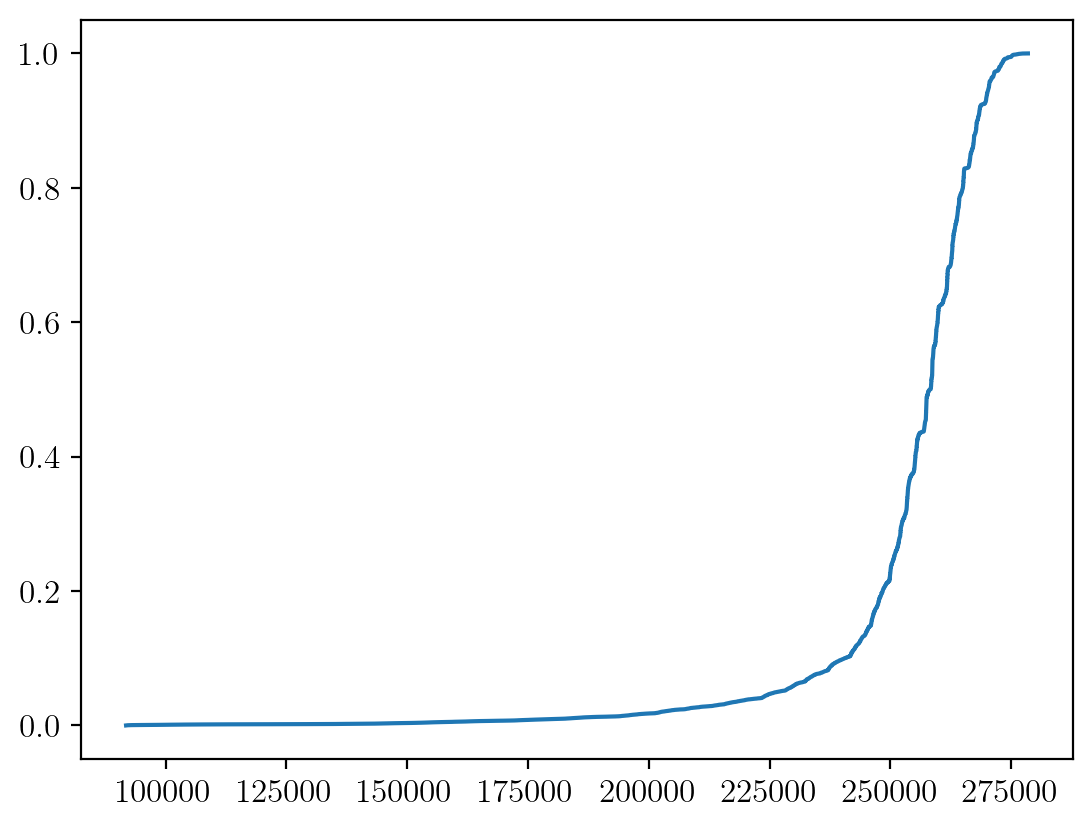

In [13]:
plt.plot(np.sort(g_r.df['orderer']))
plt.show()

In [11]:
g_r.n_tiles

128765

In [12]:
B_lams = np.array([g_r.df[f'B_lams{i}'].min() for i in range(50)])
lamss = g_r.df['lams'].min()
B_lams, lamss, B_lams.mean(), lamss - B_lams.mean()

(array([0.01415461, 0.01463434, 0.01374372, 0.01436333, 0.01422988, 0.01402769, 0.01409128,
        0.01462664, 0.01439797, 0.01452572, 0.01422988, 0.01422988, 0.01471439, 0.01465595,
        0.01438508, 0.01395343, 0.01439868, 0.01422987, 0.01453321, 0.01373493, 0.01375533,
        0.01438508, 0.01465595, 0.01404592, 0.01464996, 0.01422098, 0.01429261, 0.01462047,
        0.01414662, 0.01442387, 0.01424556, 0.01429829, 0.01422987, 0.01447258, 0.01438508,
        0.01464653, 0.01447258, 0.01404592, 0.01434448, 0.01365711, 0.01434448, 0.01422987,
        0.01409344, 0.01417179, 0.01451536, 0.01424556, 0.01422851, 0.01422987, 0.01422987,
        0.01438508], dtype=float32),
 0.014398683,
 0.014290583,
 0.00010809954)

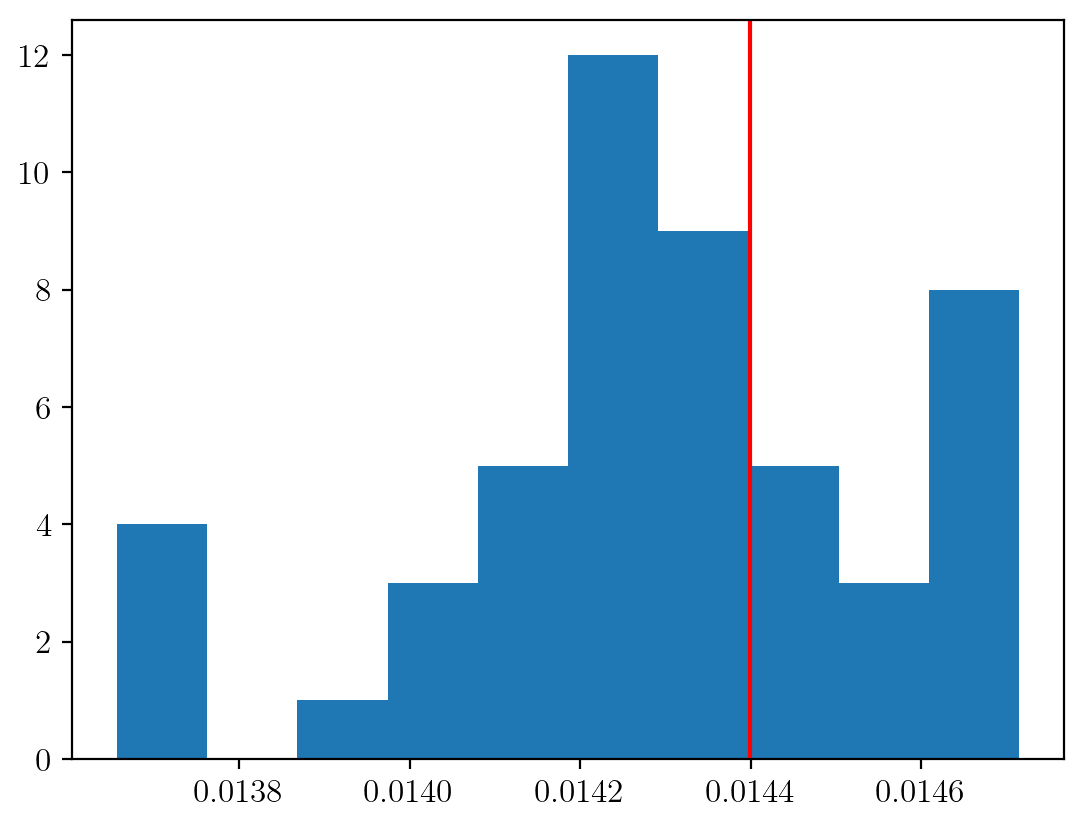

In [13]:

plt.hist(B_lams)
plt.axvline(lamss, color='r')
plt.show()

In [14]:
ordering = g_r.df['orderer'].sort_values()
ordering

100470    0.013712
92814     0.013712
108182    0.013712
108186    0.013712
108192    0.013712
            ...   
16093     0.907981
16096     0.907981
16095     0.908175
7395      0.908504
1614      0.910559
Name: orderer, Length: 128765, dtype: float64

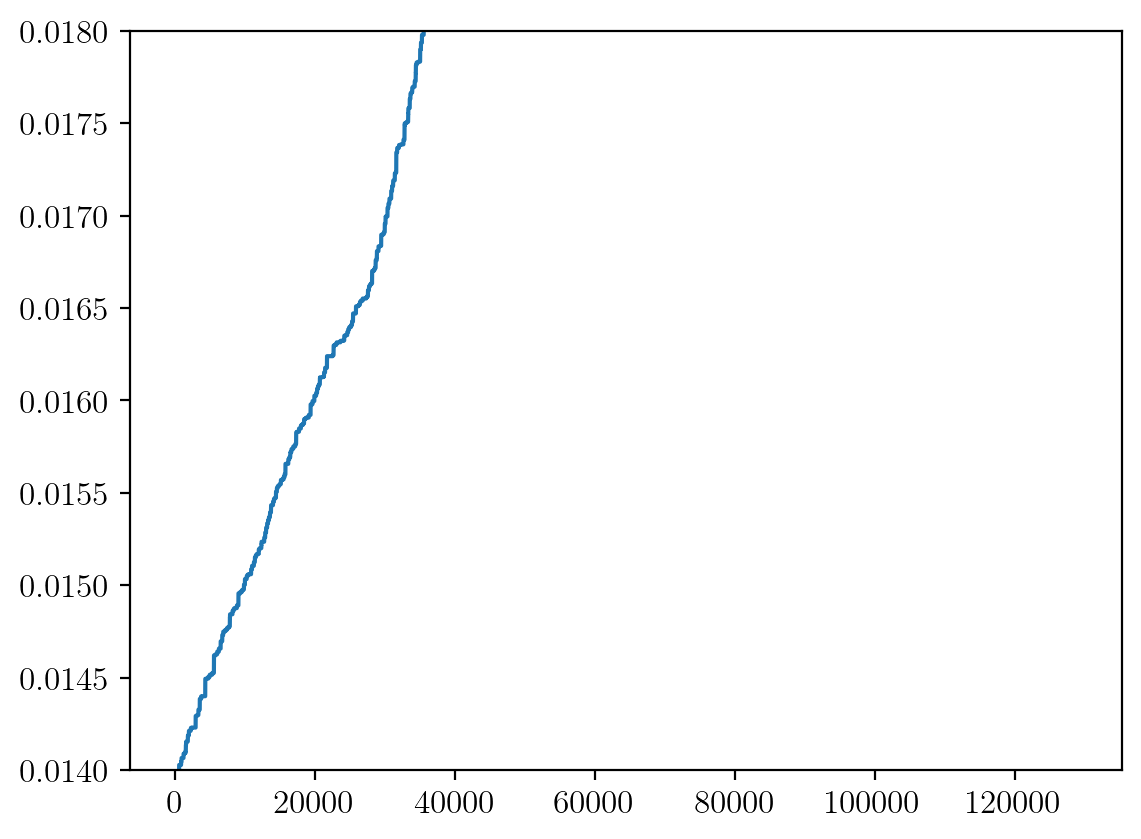

In [20]:
plt.plot(ordering.values)
plt.ylim([0.014, 0.018])
plt.show()

In [21]:
worst_tile = g_r.df.loc[g_r.df['lams'].idxmin()]
worst_tile[['theta0', 'theta1', 'radii0', 'radii1', 'orderer', "alpha0", 'K', 'lams']]

theta0    -1.001172
theta1    -0.997461
radii0     0.000391
radii1     0.001367
orderer    0.013712
alpha0     0.024625
K             65536
lams       0.014399
Name: 92814, dtype: object

In [17]:
np.searchsorted(ordering, worst_tile['orderer']), ordering.shape

(0, (128765,))

In [18]:
B_worst_tile = [g_r.df.loc[g_r.df[f'B_lams{i}'].idxmin()] for i in range(50)]
[(B_worst_tile[i]['orderer'], np.searchsorted(ordering, B_worst_tile[i]['orderer'])) for i in range(50)]

[(0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 (0.01402769424021244, 600),
 (0.01402769424021244, 600),
 (0.013712042942643166, 0),
 (0.013712042942643166, 0),
 

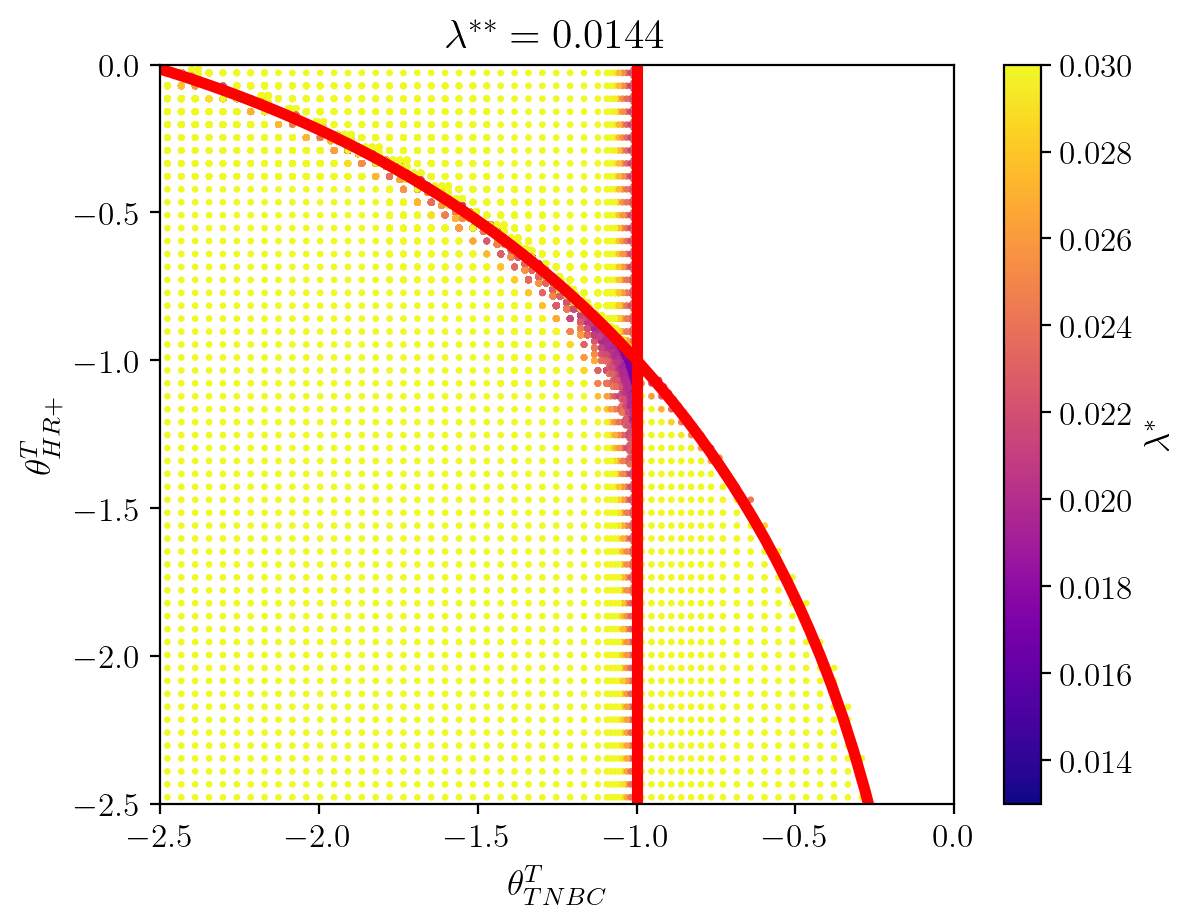

In [23]:
theta = g_r.get_theta()
p = expit(theta)
f = model.true_frac_tnbc
ptt = expit(np.linspace(-2.5, theta[:,1].max(), 100))
pht = ((p_tnbc_c * f + p_hrplus_c * (1 - f)) - (ptt * f)) / (1 - f)
plt.scatter(theta[:,0], theta[:,1], c=g_r.df['lams'], s=2, vmin=0.013, vmax=0.03)
plt.axvline(theta_tnbc_c, color='red', linewidth=4)
plt.plot(logit(ptt), logit(pht), color='red', linewidth=4)
cbar = plt.colorbar()
cbar.set_label('$\lambda^{*}$')
plt.xlabel(r'$\theta_{TNBC}^{T}$')
plt.ylabel(r'$\theta_{HR+}^{T}$')
plt.xlim([-2.5, 0.0])
plt.ylim([-2.5, 0.0])
plt.title('$\lambda^{**}='+f'{lamss:.4f}$')
plt.show()

In [45]:
from jax.scipy.special import expit
results = jax.vmap(model.sim, in_axes=(0, None, None, None, None, None))(
    model.unifs[:1000], p_tnbc_c, expit(-1.0), p_hrplus_c, expit(1.0), True
)

lamss = 0.0239
import pandas as pd
df = pd.DataFrame(results)
df['rej_full'] = df['full_stat'] < lamss
df['rej_tnbc'] = df['tnbc_stat'] < lamss
df.head()

,HI_zcombined,full_stat,hypfull_zstat,hypofull_live,hypotnbc_live,hyptnbc_zstat,tnbc_stat,zfull_stage1,zfull_stage2,ztnbc_stage1,ztnbc_stage2,rej_full,rej_tnbc
0,1.677172,0.046754,1.882450,True,False,-1.309097,0.904749,2.161197,0.500988,-1.162869,-0.688474,False,False
1,3.309248,0.000468,3.496170,True,False,0.556655,0.288882,2.410580,2.533751,0.286446,0.500783,True,False
2,3.329800,0.000435,3.522123,True,False,0.332004,0.369943,2.332458,2.648576,0.723627,-0.254103,True,False
3,4.472816,0.000004,4.588161,True,False,0.832550,0.202549,4.098088,2.390551,1.463850,-0.286446,True,False
4,3.792567,0.000075,3.939487,True,False,-0.062377,0.524869,3.160696,2.410580,-0.324657,0.236442,True,False


In [46]:
df.loc[df['rej_tnbc']]

,HI_zcombined,full_stat,hypfull_zstat,hypofull_live,hypotnbc_live,hyptnbc_zstat,tnbc_stat,zfull_stage1,zfull_stage2,ztnbc_stage1,ztnbc_stage2,rej_full,rej_tnbc
38,4.930005,4.111376e-07,5.044601,True,False,2.680559,0.003675,4.132424,3.001720,1.951800,1.839083,True,True
183,4.616590,1.950487e-06,4.753480,True,False,2.279196,0.011328,3.415073,3.307364,1.313631,1.909640,True,True
244,5.784158,3.643824e-09,5.889882,True,False,2.478750,0.006592,4.488641,3.840910,2.003132,1.502349,True,True
292,5.603102,1.052749e-08,5.746051,True,False,2.382713,0.008593,3.257502,4.868642,1.366533,2.003132,True,True
317,6.534589,3.189220e-11,6.634014,True,False,2.265775,0.011733,4.821160,4.560752,1.549194,1.655096,True,True
374,5.952938,1.316859e-09,6.063214,True,False,2.202515,0.013814,4.286187,4.288493,1.729186,1.385641,True,True
395,5.517431,1.719954e-08,5.643636,True,False,2.017920,0.021800,3.728770,4.252536,0.788178,2.065591,True,True
454,6.419673,6.828360e-11,6.550988,True,False,2.708091,0.003384,3.572131,5.692366,0.487950,3.341870,True,True
482,5.922977,1.580822e-09,6.055137,True,False,2.500945,0.006193,3.547251,5.016005,2.223239,1.313631,True,True
501,4.566278,2.482299e-06,4.713284,True,False,2.099207,0.017899,3.158673,3.506918,1.655096,1.313631,True,True
